### Imports

In [37]:
import pandas as pd
from pandas_datareader import data
from datetime import datetime
import matplotlib.pyplot as plt
import time

### Obtain and Prepare Data

In [38]:
start = datetime.strptime('2020-01-02','%Y-%m-%d')
end = datetime.strptime('2022-02-28','%Y-%m-%d')

df = data.DataReader('GME',start=start, end=end, data_source='yahoo')
df = df[:1500]['Close']

In [39]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(np.array(df).reshape(-1,1))

In [40]:
training_size=int(len(data)*0.65)
test_size=len(data)-training_size
train_data,test_data=data[0:training_size,:],data[training_size:len(data),:]

In [41]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [42]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [43]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

### Build and Train LSTM

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [45]:
model=Sequential() 
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1))) 
model.add(LSTM(50,return_sequences=True)) 
model.add(LSTM(50)) 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error',optimizer='adam')

In [46]:
start= time.time()
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)
end=time.time()

Epoch 1/100
4/4 [==============================] - 4s 380ms/step - loss: 0.0516 - val_loss: 0.0207
Epoch 2/100
4/4 [==============================] - 0s 121ms/step - loss: 0.0304 - val_loss: 0.0154
Epoch 3/100
4/4 [==============================] - 0s 114ms/step - loss: 0.0199 - val_loss: 0.0100
Epoch 4/100
4/4 [==============================] - 0s 116ms/step - loss: 0.0203 - val_loss: 0.0064
Epoch 5/100
4/4 [==============================] - 0s 113ms/step - loss: 0.0171 - val_loss: 0.0279
Epoch 6/100
4/4 [==============================] - 0s 120ms/step - loss: 0.0177 - val_loss: 0.0098
Epoch 7/100
4/4 [==============================] - 0s 114ms/step - loss: 0.0154 - val_loss: 0.0047
Epoch 8/100
4/4 [==============================] - 0s 110ms/step - loss: 0.0159 - val_loss: 0.0045
Epoch 9/100
4/4 [==============================] - 0s 109ms/step - loss: 0.0156 - val_loss: 0.0088
Epoch 10/100
4/4 [==============================] - 0s 113ms/step - loss: 0.0152 - val_loss: 0.0078
Epoch 11/

4/4 [==============================] - 0s 119ms/step - loss: 0.0058 - val_loss: 0.0129
Epoch 84/100
4/4 [==============================] - 0s 127ms/step - loss: 0.0058 - val_loss: 0.0153
Epoch 85/100
4/4 [==============================] - 0s 124ms/step - loss: 0.0056 - val_loss: 0.0125
Epoch 86/100
4/4 [==============================] - 0s 116ms/step - loss: 0.0056 - val_loss: 0.0163
Epoch 87/100
4/4 [==============================] - 0s 124ms/step - loss: 0.0055 - val_loss: 0.0122
Epoch 88/100
4/4 [==============================] - 0s 123ms/step - loss: 0.0054 - val_loss: 0.0173
Epoch 89/100
4/4 [==============================] - 0s 130ms/step - loss: 0.0054 - val_loss: 0.0129
Epoch 90/100
4/4 [==============================] - 0s 114ms/step - loss: 0.0058 - val_loss: 0.0169
Epoch 91/100
4/4 [==============================] - 0s 130ms/step - loss: 0.0051 - val_loss: 0.0114
Epoch 92/100
4/4 [==============================] - 0s 120ms/step - loss: 0.0051 - val_loss: 0.0122
Epoch 93/100


### Make Predictions

In [47]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Visualize Results

<function matplotlib.pyplot.show(close=None, block=None)>

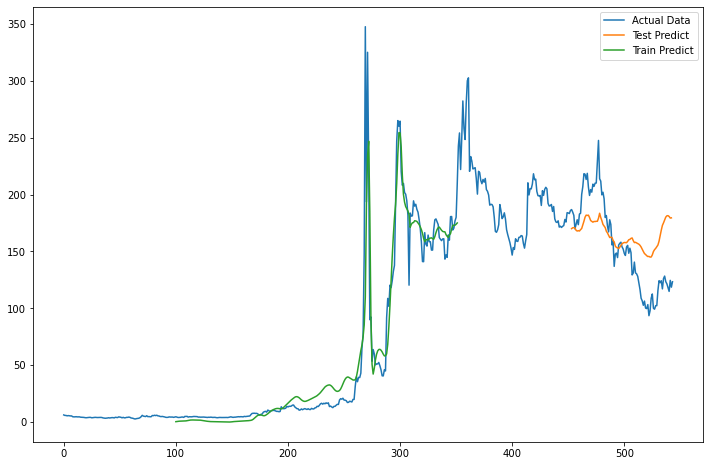

In [48]:
look_back=time_step
trainPredictPlot=np.empty_like(data)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict

testPredictPlot=np.empty_like(data)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1,:] = test_predict

plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(data))
plt.plot(testPredictPlot)
plt.plot(trainPredictPlot)
plt.legend(['Actual Data','Test Predict','Train Predict'])

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

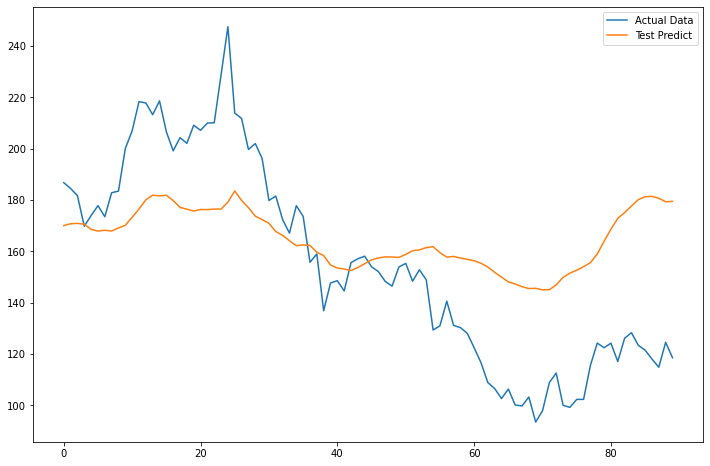

In [49]:
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(data)[len(train_predict)+(look_back*2)+1:len(data)-1])
plt.plot(test_predict)
plt.legend(['Actual Data','Test Predict'])
plt.show

### Evaluation

In [50]:
from sklearn.metrics import mean_squared_error
test_predict=model.predict(X_test)
print('MSE:',mean_squared_error(y_test, test_predict))

MSE: 0.009738825350080919


In [51]:
print('Volatility:',np.log(df/df.shift()).std()*252**0.5)

Volatility: 1.7885089016635345


In [52]:
print('Time taken for training in seconds:',end-start)

Time taken for training in seconds: 50.81039619445801
